In [1]:
from common.camera import *

load dataset

In [2]:
dataset_path = "./data/data_3d_h36m.npz"

In [3]:
print('Loading dataset...')
from common.h36m_dataset import Human36mDataset
dataset = Human36mDataset(dataset_path)

Loading dataset...


In [4]:
print('Preparing data...')
for subject in dataset.subjects():
    for action in dataset[subject].keys():
        anim = dataset[subject][action]
        
        positions_3d = []
        
        for cam in anim['cameras']:
            pos_3d = anim['positions']
#             pos_3d = world_to_camera(anim['positions'], R=cam['orientation'], t=cam['translation'])
#             pos_3d[:, 1:] -= pos_3d[:, :1] # Remove global offset, but keep trajectory in first position
            positions_3d.append(pos_3d)

        anim['positions_3d'] = positions_3d

Preparing data...


load 2D detections

In [5]:
keypoints = np.load('./data/data_2d_h36m_cpn_ft_h36m_dbb.npz', allow_pickle = True)
keypoints = keypoints['positions_2d'].item()

In [6]:
keypoints["S1"].keys()

dict_keys(['Directions', 'Smoking', 'Posing 1', 'Photo', 'Eating', 'WalkTogether 1', 'Waiting 1', 'Sitting 1', 'WalkDog', 'Purchases', 'Walking', 'Phoning 1', 'Eating 2', 'SittingDown 2', 'Posing', 'WalkDog 1', 'Greeting', 'Purchases 1', 'Smoking 1', 'Photo 1', 'Discussion 1', 'SittingDown', 'Directions 1', 'WalkTogether', 'Phoning', 'Discussion', 'Greeting 1', 'Waiting', 'Sitting 2', 'Walking 1'])

In [7]:
viz_subject = "S1"
# viz_action = "Posing 1"
#viz_action = "Walking 1"
viz_action = "Phoning 1"


viz_camera = 0

In [8]:
from common.visualization import *

In [9]:
cam = dataset.cameras()[viz_subject][viz_camera]

In [10]:
input_keypoints = keypoints[viz_subject][viz_action][viz_camera].copy()
input_keypoints = image_coordinates(input_keypoints[..., :2], w=cam['res_w'], h=cam['res_h'])

In [11]:
ground_truth = dataset._data[viz_subject][viz_action]['positions_3d'][viz_camera].copy()

In [12]:
anim_output = {'Reconstruction': ground_truth}
anim_output['Ground truth'] = ground_truth

In [13]:
keypoints = input_keypoints
poses = anim_output
skeleton = dataset.skeleton()
parents = skeleton.parents()
viewport=(cam['res_w'], cam['res_h'])

In [14]:
for index, (title, data) in enumerate(poses.items()):
    print(index, title, data.shape)

0 Ground truth (2636, 17, 3)
1 Reconstruction (2636, 17, 3)


In [15]:
# render_animation(input_keypoints, 
#                  anim_output,
#                  dataset.skeleton(), 
#                  dataset.fps(), 
#                  3000, 
#                  cam['azimuth'], 
#                  "out.gif",
#                  limit=100, 
#                  downsample=10, 
#                  size=5,
#                  viewport=(cam['res_w'], cam['res_h']))

In [16]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np
%matplotlib inline

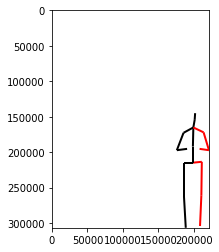

In [17]:
display_2D_skeleton(keypoints[81], skeleton)

In [18]:
poses["Ground truth"].shape

(2636, 17, 3)

In [28]:
cam

{'azimuth': array(70., dtype=float32),
 'center': array([0.02508307, 0.02890298], dtype=float32),
 'focal_length': array([2.290099 , 2.2875624], dtype=float32),
 'id': '54138969',
 'intrinsic': array([ 2.2900989e+00,  2.2875624e+00,  2.5083065e-02,  2.8902981e-02,
        -2.0709892e-01,  2.4777518e-01, -3.0751503e-03, -9.7569887e-04,
        -1.4244716e-03], dtype=float32),
 'orientation': array([ 0.14070565, -0.15007018, -0.7552408 ,  0.62232804], dtype=float32),
 'radial_distortion': array([-0.20709892,  0.24777518, -0.00307515], dtype=float32),
 'res_h': 1002,
 'res_w': 1000,
 'tangential_distortion': array([-0.0009757 , -0.00142447], dtype=float32),
 'translation': array([1.841107 , 4.9552846, 1.5634454], dtype=float32)}

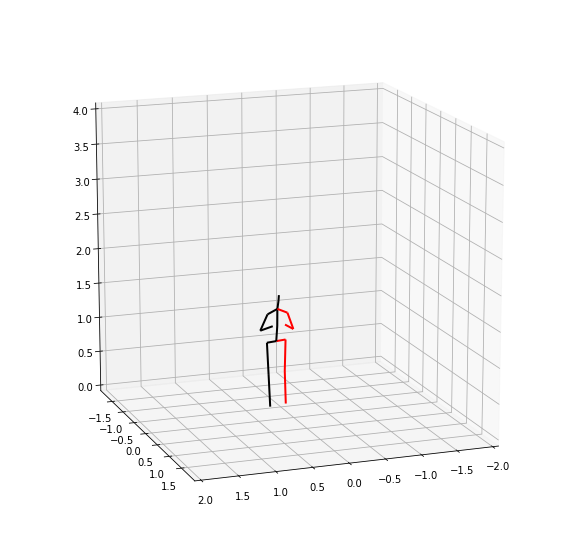

In [19]:
display_3D_skeleton(poses["Ground truth"][81], skeleton, cam['azimuth'])

In [20]:
anim = dataset[viz_subject][viz_action]
cam = anim['cameras'][0]
pos_3d_cam = world_to_camera(anim['positions'], R=cam['orientation'], t=cam['translation'])

In [21]:
trajectory = np.array([[pos_3d[i,0,0], pos_3d[i,0,1], pos_3d[i,0,2], pos_3d[i+1,0,0], pos_3d[i+1,0,1], pos_3d[i+1,0,2],]for i in range(1000)])

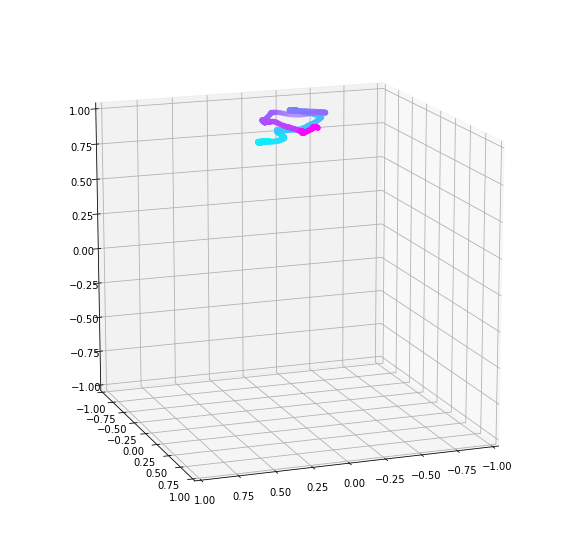

In [22]:
fig = plt.figure(figsize=(10,10))
ax_traj = fig.gca(projection='3d')
ax_traj.scatter(trajectory[:,0], 
             trajectory[:,1], 
             trajectory[:,2], c = [i/len(trajectory[:,0]) for i in range(len(trajectory[:,0]))], cmap='cool')
ax_traj.view_init(elev=15., azim=cam['azimuth'])
ax_traj.set_xlim3d([-1, 1])
ax_traj.set_ylim3d([-1, 1])
ax_traj.set_zlim3d([-1, 1])

plt.show()

In [23]:
def display_3D_skeleton_beta(pos, skeleton, azim):
    line_3d_segs = []
    cols = []
    for j, j_parent in enumerate(skeleton.parents()):
        if j_parent == -1:
            continue

        col = 'red' if j in skeleton.joints_right() else 'black'
        cols.append(col)
        line_3d_segs.append([(pos[j, 0], pos[j, 1], pos[j, 2]), (pos[j_parent, 0], pos[j_parent, 1], pos[j_parent, 2])])
        
    lc = Line3DCollection(line_3d_segs, colors=cols, linewidths=2)
    fig = plt.figure(figsize=(10,10))
    
    ax_3d = fig.add_subplot(1,1,1,projection='3d')
    ax_3d.add_collection3d(lc, zdir='z')
    m = 15
    ax_3d.scatter(pos[m, 0], pos[m, 1], pos[m, 2], color="g", s=50)
    ax_3d.view_init(elev=130., azim=azim)
    ax_3d.dist = 10
    ax_3d.axis('equal')
    ax_3d.set_xlabel("x")
    ax_3d.set_ylabel("y")
    ax_3d.set_zlabel("z")
    ax_3d.set_xlim3d([-0, 5])
    ax_3d.set_ylim3d([-0, 6])
    ax_3d.set_zlim3d([-0, 5])
    
    plt.show()

In [24]:
skeleton.parents()

array([-1,  0,  1,  2,  0,  4,  5,  0,  7,  8,  9,  8, 11, 12,  8, 14, 15])

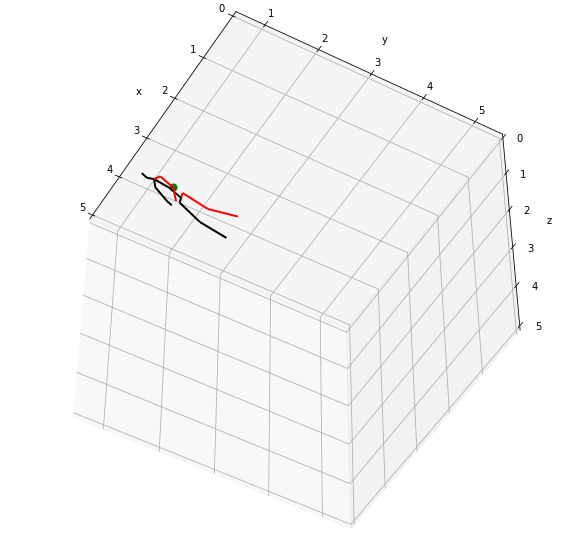

In [25]:
display_3D_skeleton_beta(pos_3d_cam[300], skeleton, 30)

In [26]:
pos_3d_cam_2 = pos_3d_cam.copy()
pos_3d_cam_2[:, 1:] -= pos_3d_cam_2[:, :1]

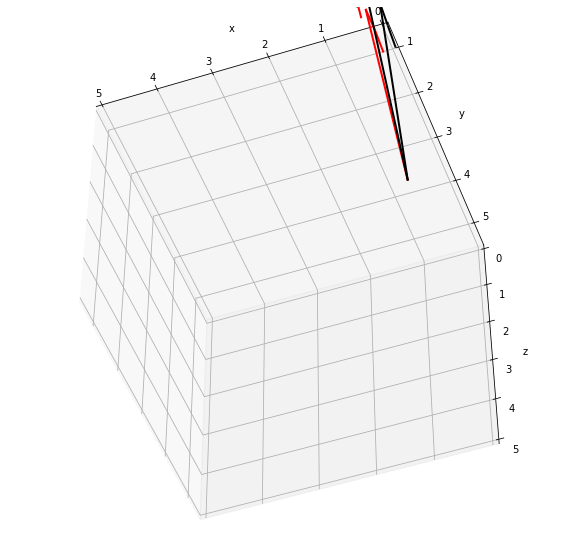

In [27]:
display_3D_skeleton_beta(pos_3d_cam_2[0], skeleton, 70)